In [15]:
from pathlib import Path

data_dir = Path.cwd() / "data"
assert data_dir.exists(), f"Data directory does not exist: {data_dir}"

In [16]:
from enum import Enum

import numpy as np
import h5py

import torch
import torchmetrics
from lightning.pytorch import LightningDataModule, LightningModule, Trainer
from lightning.pytorch.loggers import WandbLogger

from matplotlib import pyplot as plt
import seaborn as sns
import wandb

# Seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

torch.set_float32_matmul_precision("medium")

In [17]:
wandb.login()

True

In [18]:
CHANNEL_NAMES = ["time_s",
                 "K1_Ch1_Mod2/AI0",  # Rondenschnitt direkt
                 "K1_Ch2_Mod2/AI1",  # Tiefziehen direkt
                 "K1_Ch3_Mod2/AI2",  # Abstrecken direkt
                 "K2_Ch1_Mod2/AI3",  # Tiefziehen oben indirekt
                 "K2_Ch2_Mod2/AI4",  # Tiefziehen unten direkt
                 "K2_Ch3_Mod2/AI5",  # nicht angeschlossen
                 "K3_Ch1_Mod2/AI6",  # Abstrecken oben indrekt
                 "K3_Ch2_Mod2/AI7",  # Abstrecken Stempehalter indirekt
                 "K3_Ch3_Mod2/AI8",  # Abstrecken unten indirekt
                 "Mod2/AI9",         # in Klärung
                 "Mod7 A0",          # Thermospannung 1
                 "Mod7 A1",          # Thermospannung 2
                 "Mod7 A2",          # in Klärung
                 "Mod7 A3",          # in Klärung
                 ]


class SignalPortion(Enum):
    DIRECT = [1, 2, 3, 5]
    INDIRECT = [4, 7, 8, 9]
    ALL = list(range(1, len(CHANNEL_NAMES)))


class SheetMetalDataset(torch.utils.data.Dataset):
    """Dataset for sheet metal forming measurements."""

    def __init__(self, data: np.ndarray, metadata: dict):
        """
        Args:
            data: Array of shape (n_entries, n_signals, n_points)
            metadata: Dict with T, A arrays
        """
        self.data = torch.from_numpy(data).float()
        self.T = torch.from_numpy(metadata["T"]).long()
        self.A = torch.from_numpy(metadata["A"]).long()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            "data": self.data[idx],
            "T": self.T[idx],
            "A": self.A[idx],
        }


class SheetMetalDataModule(LightningDataModule):
    """LightningDataModule for sheet metal forming data."""

    def __init__(
        self,
        data_path: Path,
        signal_portion: SignalPortion,
        batch_size: int = 32,
        num_workers: int = 4,
        train_ratio: float = 0.7,
        val_ratio: float = 0.1,
        seed: int = 42,
    ):
        super().__init__()
        self.data_path = data_path
        self.signal_portion = signal_portion
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio
        self.seed = seed

        self.save_hyperparameters(ignore=["data_path"])

    def setup(self, stage: str = None):
        # Load data from HDF5
        with h5py.File(self.data_path, "r") as h5f:
            signal_indices = self.signal_portion.value
            data = h5f["data"][:, signal_indices, :]
            all_signal_keys = [k for k in h5f["data"].attrs["signal_keys"]]
            self.signal_keys = [all_signal_keys[i] for i in signal_indices]
            metadata = {
                "T": h5f["meta_data/T"][:],
                "A": h5f["meta_data/A"][:],
            }

        # Filter out samples where T == 0 or A == 0
        valid_mask = (metadata["T"] != 0) & (metadata["A"] != 0)
        data = data[valid_mask]
        metadata = {k: v[valid_mask] for k, v in metadata.items()}
        print(
            f"Filtered {(~valid_mask).sum()} samples with T=0 or A=0, {valid_mask.sum()} remaining")

        # Reproducible shuffle and split
        rng = np.random.default_rng(self.seed)
        indices = rng.permutation(len(data))

        n_train = int(len(data) * self.train_ratio)
        n_val = int(len(data) * self.val_ratio)

        def make_dataset(idx):
            return SheetMetalDataset(data[idx], {k: v[idx] for k, v in metadata.items()})

        self.train_dataset = make_dataset(indices[:n_train])
        self.val_dataset = make_dataset(indices[n_train:n_train + n_val])
        self.test_dataset = make_dataset(indices[n_train + n_val:])

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
        )


data_module = SheetMetalDataModule(
    data_path=data_dir / "all_data.hdf5",
    signal_portion=SignalPortion.INDIRECT,
)
data_module.setup()

Filtered 500 samples with T=0 or A=0, 4500 remaining


In [19]:
# Test the data module
print(f"Signal keys: {data_module.signal_keys}")
print(f"Train samples: {len(data_module.train_dataset)}")
print(f"Val samples: {len(data_module.val_dataset)}")
print(f"Test samples: {len(data_module.test_dataset)}")

# Check a batch
batch = next(iter(data_module.train_dataloader()))
print(f"\nBatch data shape: {batch['data'].shape}")
print(f"Batch T: {batch['T']}")
print(f"Batch A: {batch['A']}")

Signal keys: ['K2_Ch1_Mod2__AI3', 'K3_Ch1_Mod2__AI6', 'K3_Ch2_Mod2__AI7', 'K3_Ch3_Mod2__AI8']
Train samples: 3150
Val samples: 450
Test samples: 900

Batch data shape: torch.Size([32, 4, 1200])
Batch T: tensor([1, 3, 2, 2, 1, 2, 3, 2, 2, 3, 1, 1, 2, 3, 3, 2, 2, 1, 2, 1, 3, 3, 1, 3,
        3, 2, 1, 1, 2, 1, 3, 3])
Batch A: tensor([3, 3, 1, 1, 1, 2, 2, 1, 3, 1, 2, 3, 1, 2, 1, 2, 3, 1, 2, 2, 3, 2, 3, 2,
        3, 3, 1, 2, 1, 3, 3, 2])


Sample data shape: torch.Size([4, 1200])
Sample T: 1
Sample A: 3


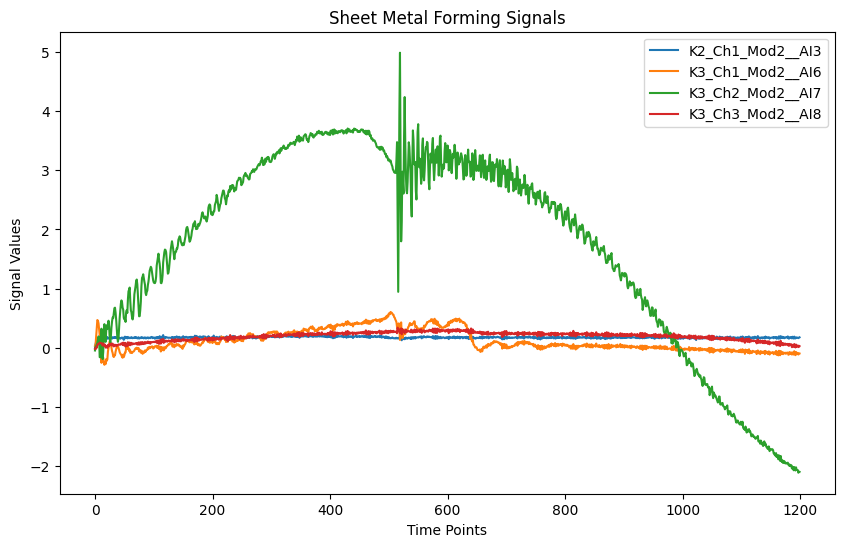

In [20]:
# Show one instance
sample = data_module.train_dataset[0]
print("Sample data shape:", sample["data"].shape)
print("Sample T:", sample["T"].item())
print("Sample A:", sample["A"].item())
plt.figure(figsize=(10, 6))
for i, signal in enumerate(data_module.signal_keys):
    plt.plot(sample["data"][i].numpy(), label=signal)
plt.title("Sheet Metal Forming Signals")
plt.xlabel("Time Points")
plt.ylabel("Signal Values")
plt.legend()
plt.show()

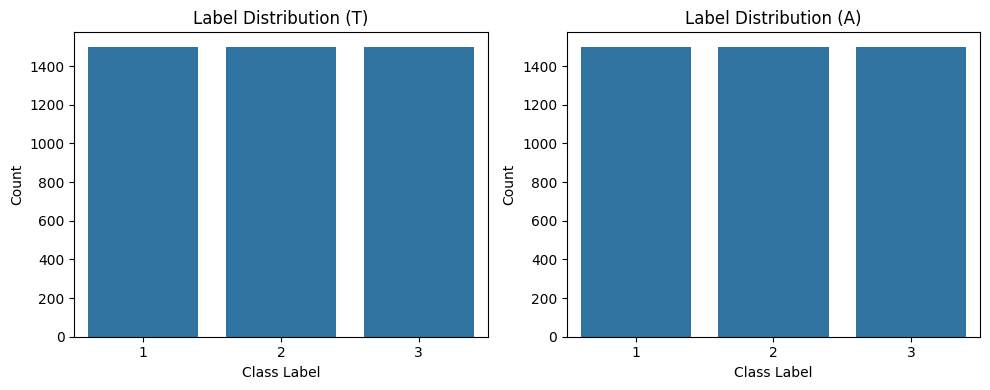

In [21]:
# Plot class label frequencies for T, A
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for ax, label in zip(axes, ["T", "A"]):
    all_labels = torch.cat([
        getattr(data_module.train_dataset, label),
        getattr(data_module.val_dataset, label),
        getattr(data_module.test_dataset, label),
    ])
    unique, counts = torch.unique(all_labels, return_counts=True)
    freq = counts.float()
    sns.barplot(x=unique.numpy(), y=freq.numpy(), ax=ax)
    ax.set_title(f"Label Distribution ({label})")
    ax.set_xlabel("Class Label")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

In [ ]:
# Train a simple 1d-CNN to predict T, A from signals

def conv_block(in_ch, out_ch, kernel_size, pool_size, dropout):
    return torch.nn.Sequential(
        torch.nn.Conv1d(in_ch, out_ch, kernel_size, padding=kernel_size // 2),
        torch.nn.BatchNorm1d(out_ch),
        torch.nn.ReLU(),
        torch.nn.MaxPool1d(pool_size),
        torch.nn.Dropout(dropout),
    )


class SimpleCNN(LightningModule):
    def __init__(self, n_signals: int, n_classes: dict, lr: float = 5e-4, dropout: float = 0.25):
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr
        self.n_classes = n_classes

        # 1200 -> 600 -> 150 -> 37 -> 9 -> 1
        self.backbone = torch.nn.Sequential(
            conv_block(n_signals, 32, kernel_size=7,
                       pool_size=2, dropout=dropout * 0.5),
            conv_block(32, 64, kernel_size=5, pool_size=4,
                       dropout=dropout * 0.5),
            conv_block(64, 128, kernel_size=5, pool_size=4, dropout=dropout),
            conv_block(128, 256, kernel_size=3, pool_size=4, dropout=dropout),
            torch.nn.AdaptiveAvgPool1d(1),
            torch.nn.Flatten(),
            torch.nn.Dropout(dropout),
        )

        self.head_T = torch.nn.Linear(256, n_classes["T"])
        self.head_A = torch.nn.Linear(256, n_classes["A"])

        self.criterion = torch.nn.CrossEntropyLoss()

        # Metrics for each stage and label
        for stage in ["train", "val", "test"]:
            for label, num_classes in n_classes.items():
                setattr(self, f"{stage}_acc_{label}",
                        torchmetrics.Accuracy(task="multiclass", num_classes=num_classes))
                setattr(self, f"{stage}_f1_{label}",
                        torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average="macro"))

    def forward(self, x):
        features = self.backbone(x)
        return self.head_T(features), self.head_A(features)

    def _step(self, batch, stage: str):
        data, T, A = batch["data"], batch["T"], batch["A"]
        T_out, A_out = self(data)

        loss = (self.criterion(T_out, T) +
                self.criterion(A_out, A))

        # Update and log metrics
        preds = {"T": T_out, "A": A_out}
        targets = {"T": T, "A": A}

        for label in ["T", "A"]:
            acc = getattr(self, f"{stage}_acc_{label}")
            f1 = getattr(self, f"{stage}_f1_{label}")
            acc(preds[label], targets[label])
            f1(preds[label], targets[label])
            self.log(f"{stage}_acc_{label}", acc, prog_bar=(stage != "train"))
            self.log(f"{stage}_f1_{label}", f1, prog_bar=(stage != "train"))

        self.log(f"{stage}_loss", loss, prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self._step(batch, "val")

    def test_step(self, batch, batch_idx):
        return self._step(batch, "test")

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.lr)


# Check label ranges
train_T, train_A = data_module.train_dataset.T, data_module.train_dataset.A
print(f"T: {train_T.min().item()}-{train_T.max().item()}, A: {train_A.min().item()}-{train_A.max().item()}")

n_classes = {"T": train_T.max().item() + 1, "A": train_A.max().item() + 1}
print(f"n_classes: {n_classes}")

model = SimpleCNN(n_signals=len(data_module.signal_keys), n_classes=n_classes)

T: 1-3, A: 1-3
n_classes: {'T': 4, 'A': 4}


In [23]:
# Show data shapes through the model
from torchinfo import summary

# Get input shape from data
sample_batch = next(iter(data_module.train_dataloader()))
input_shape = sample_batch["data"].shape  # (batch, n_signals, n_points)

summary(model, input_size=input_shape, col_names=[
        "input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SimpleCNN                                [32, 4, 1200]             [32, 4]                   --
├─Sequential: 1-1                        [32, 4, 1200]             [32, 256]                 --
│    └─Sequential: 2-1                   [32, 4, 1200]             [32, 32, 600]             --
│    │    └─Conv1d: 3-1                  [32, 4, 1200]             [32, 32, 1200]            928
│    │    └─BatchNorm1d: 3-2             [32, 32, 1200]            [32, 32, 1200]            64
│    │    └─ReLU: 3-3                    [32, 32, 1200]            [32, 32, 1200]            --
│    │    └─MaxPool1d: 3-4               [32, 32, 1200]            [32, 32, 600]             --
│    │    └─Dropout: 3-5                 [32, 32, 600]             [32, 32, 600]             --
│    └─Sequential: 2-2                   [32, 32, 600]             [32, 64, 150]             --
│    │    └─Conv1d: 3-6           

In [24]:
# Initialize WandB logger for learning curve tracking
wandb_logger = WandbLogger(project="sheet-metal-forming", name="SimpleCNN")

# Log hyperparameters
wandb_logger.experiment.config.update({
    "signal_portion": data_module.signal_portion.name,
    "n_signals": len(data_module.signal_keys),
    "batch_size": data_module.batch_size,
    "train_samples": len(data_module.train_dataset),
    "val_samples": len(data_module.val_dataset),
    "test_samples": len(data_module.test_dataset),
})

trainer = Trainer(
    max_epochs=15,
    accelerator="auto",
    devices="auto",
    precision="bf16-mixed",
    logger=wandb_logger,
)
trainer.fit(model, datamodule=data_module)

Using bfloat16 Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Filtered 500 samples with T=0 or A=0, 4500 remaining


/usr/local/lib/python3.13/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.


┏━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃    ┃ Name        ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0  │ backbone    │ Sequential         │  151 K │ train │     0 │
│ 1  │ head_T      │ Linear             │  1.0 K │ train │     0 │
│ 2  │ head_A      │ Linear             │  1.0 K │ train │     0 │
│ 3  │ criterion   │ CrossEntropyLoss   │      0 │ train │     0 │
│ 4  │ train_acc_T │ MulticlassAccuracy │      0 │ train │     0 │
│ 5  │ train_f1_T  │ MulticlassF1Score  │      0 │ train │     0 │
│ 6  │ train_acc_A │ MulticlassAccuracy │      0 │ train │     0 │
│ 7  │ train_f1_A  │ MulticlassF1Score  │      0 │ train │     0 │
│ 8  │ val_acc_T   │ MulticlassAccuracy │      0 │ train │     0 │
│ 9  │ val_f1_T    │ MulticlassF1Score  │      0 │ train │     0 │
│ 10 │ val_acc_A   │ MulticlassAccuracy │      0 │ train │     0 │
│ 11 │ val_f1_A    │ MulticlassF1Score  │      0 │ train │     0 │
│ 12 │ test_acc_T  │ MulticlassAccuracy │      0 │ train │     0 │
│ 13 │ test_f1_T   │ MulticlassF1Score  │      0 │ train │     0 │
│ 14 │ test_acc_A  │ MulticlassAccuracy │      0 │ train │     0 │
│ 15 │ test_f1_A   │ MulticlassF1Score  │      0 │ train │     0 │
└────┴─────────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 153 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 153 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 43                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

/usr/local/lib/python3.13/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)`
is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.

`Trainer.fit` stopped: `max_epochs=15` reached.


In [25]:
test_results = trainer.test(model, datamodule=data_module)
print("Test results:", test_results)

# Finish the wandb run
wandb.finish()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Filtered 500 samples with T=0 or A=0, 4500 remaining


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_acc_A         │    0.9877777695655823     │
│        test_acc_T         │    0.9766666889190674     │
│         test_f1_A         │    0.9878373742103577     │
│         test_f1_T         │    0.9765901565551758     │
│         test_loss         │    0.12061813473701477    │
└───────────────────────────┴───────────────────────────┘

Test results: [{'test_acc_T': 0.9766666889190674, 'test_f1_T': 0.9765901565551758, 'test_acc_A': 0.9877777695655823, 'test_f1_A': 0.9878373742103577, 'test_loss': 0.12061813473701477}]


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
test_acc_A,▁
test_acc_T,▁
test_f1_A,▁
test_f1_T,▁
test_loss,▁
train_acc_A,▆▅▁▁█▃▃█▆▆▆▆▅▆▆▅▆▆▅▆█▆█▅▆▆██▆
train_acc_T,▁███▅▅█████▅▅█▁███▁█▅█▅██████
train_f1_A,▆▅▁▁█▂▃█▆▆▆▆▄▆▆▄▆▆▄▆█▆█▅▆▆██▆
train_f1_T,▃███▅▅█████▅▅█▁███▁█▅█▅██████
+7,...


In [34]:
# Attribution analysis using Captum Integrated Gradients
from captum.attr import IntegratedGradients
from tqdm.auto import tqdm

# Put model in eval mode
model.eval()
model.to("cpu")

# Create wrapper functions for each head (Captum needs single output)


def forward_T(x):
    return model(x)[0]


def forward_A(x):
    return model(x)[1]


# Compute attributions for each head
ig_T = IntegratedGradients(forward_T)
ig_A = IntegratedGradients(forward_A)

# Process all test samples in batches
test_loader = data_module.test_dataloader()
all_attr_T = []
all_attr_A = []

print(
    f"Computing attributions over {len(data_module.test_dataset)} test samples...")
for test_batch in tqdm(test_loader, desc="Computing attributions"):
    inputs = test_batch["data"].cpu()
    targets = {
        "T": test_batch["T"],
        "A": test_batch["A"],
    }

    # Baseline is zeros (no signal)
    baseline = torch.zeros_like(inputs)

    # Compute attributions for this batch
    attr_T = ig_T.attribute(inputs, baselines=baseline, target=targets["T"])
    attr_A = ig_A.attribute(inputs, baselines=baseline, target=targets["A"])

    all_attr_T.append(attr_T.abs())
    all_attr_A.append(attr_A.abs())

# Concatenate all attributions and average across samples
all_attr_T = torch.cat(all_attr_T, dim=0)
all_attr_A = torch.cat(all_attr_A, dim=0)

# Average attributions across samples: (n_samples, n_signals, n_points) -> (n_signals, n_points)
avg_attr_T = all_attr_T.mean(dim=0).detach().numpy()
avg_attr_A = all_attr_A.mean(dim=0).detach().numpy()

print(f"Attribution shape: {all_attr_T.shape}")
print(f"Averaged attribution shape: {avg_attr_T.shape}")

Computing attributions over 900 test samples...


Computing attributions:   0%|          | 0/29 [00:00<?, ?it/s]

Attribution shape: torch.Size([900, 4, 1200])
Averaged attribution shape: (4, 1200)


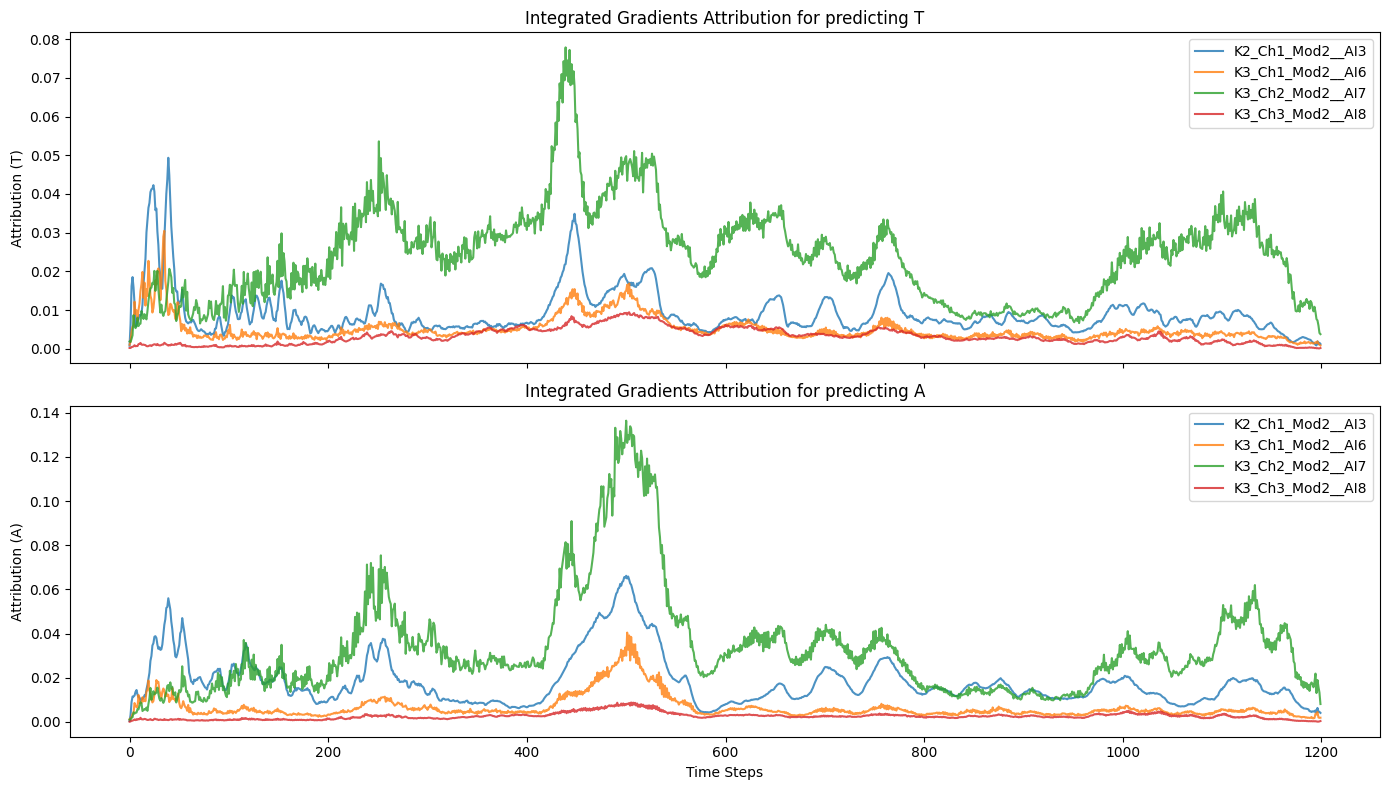

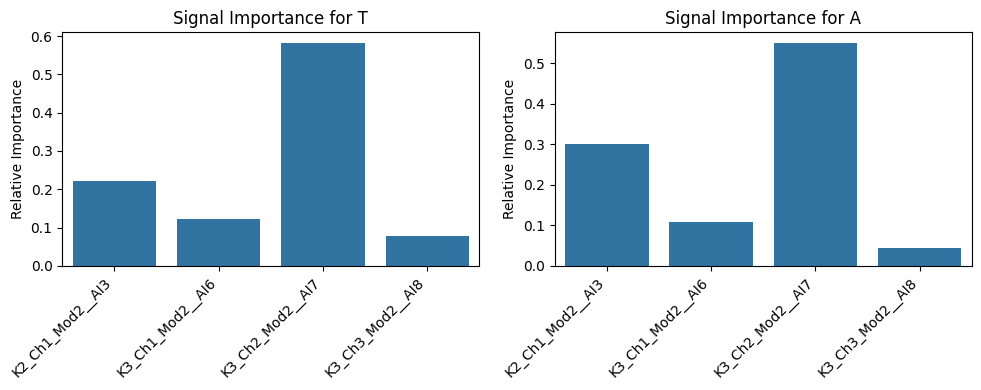

In [35]:
# Visualize attributions
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

for ax, attr, label in zip(axes, [avg_attr_T, avg_attr_A], ["T", "A"]):
    for i, signal_name in enumerate(data_module.signal_keys):
        ax.plot(attr[i], label=signal_name, alpha=0.8)
    ax.set_ylabel(f"Attribution ({label})")
    ax.set_title(f"Integrated Gradients Attribution for predicting {label}")
    ax.legend(loc="upper right")

axes[-1].set_xlabel("Time Steps")
plt.tight_layout()
plt.show()

# Also show aggregated importance per signal
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for ax, attr, label in zip(axes, [avg_attr_T, avg_attr_A], ["T", "A"]):
    # Sum attribution over time for each signal
    signal_importance = attr.sum(axis=1)
    signal_importance = signal_importance / signal_importance.sum()  # Normalize

    sns.barplot(x=list(range(len(data_module.signal_keys))),
                y=signal_importance, ax=ax)
    ax.set_xticks(range(len(data_module.signal_keys)))
    ax.set_xticklabels([s.split("/")[-1]
                       for s in data_module.signal_keys], rotation=45, ha="right")
    ax.set_ylabel("Relative Importance")
    ax.set_title(f"Signal Importance for {label}")

plt.tight_layout()
plt.show()

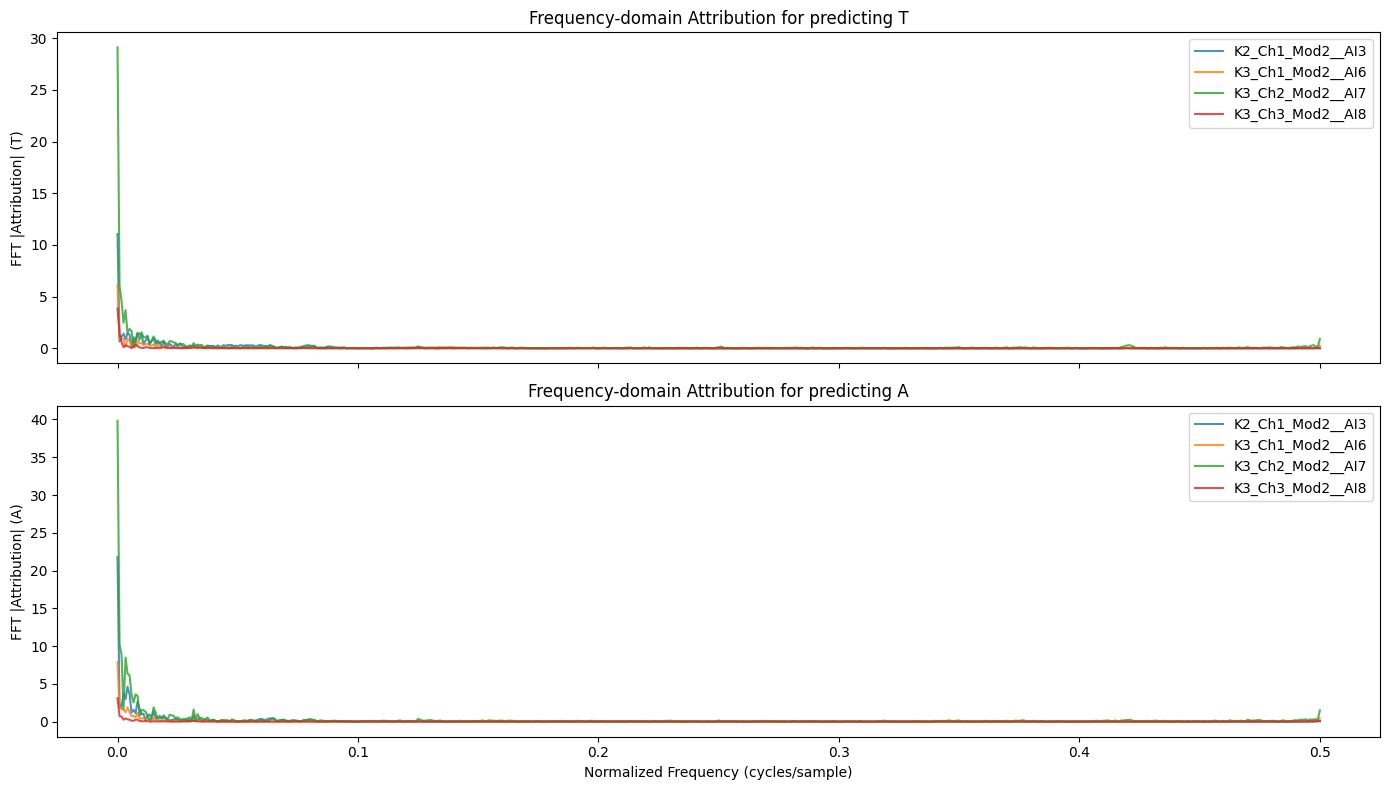

In [36]:
# Frequency-domain view of attributions (FFT)
from numpy.fft import rfft, rfftfreq

# Use normalized frequency (unit time step)
freqs = rfftfreq(avg_attr_T.shape[1], d=1.0)
fft_attr_T = np.abs(rfft(avg_attr_T, axis=1))
fft_attr_A = np.abs(rfft(avg_attr_A, axis=1))

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

for ax, fft_attr, label in zip(axes, [fft_attr_T, fft_attr_A], ["T", "A"]):
    for i, signal_name in enumerate(data_module.signal_keys):
        ax.plot(freqs, fft_attr[i], label=signal_name, alpha=0.8)
    ax.set_ylabel(f"FFT |Attribution| ({label})")
    ax.set_title(f"Frequency-domain Attribution for predicting {label}")
    ax.legend(loc="upper right")

axes[-1].set_xlabel("Normalized Frequency (cycles/sample)")
plt.tight_layout()
plt.show()

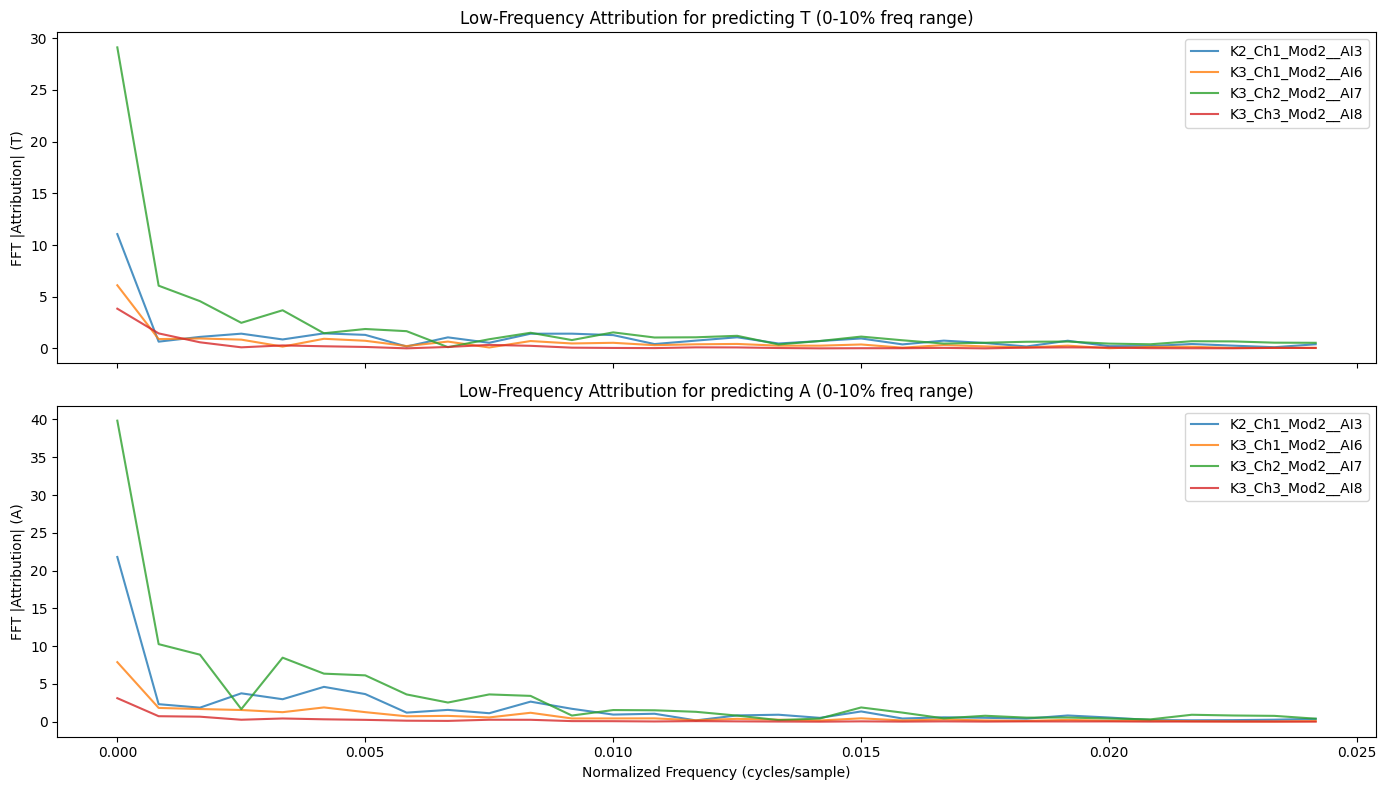

In [37]:
# Zoomed-in view of low-frequency FFT attribution (first 10%)
freq_cutoff_idx = int(len(freqs) * 0.05)

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

for ax, fft_attr, label in zip(axes, [fft_attr_T, fft_attr_A], ["T", "A"]):
    for i, signal_name in enumerate(data_module.signal_keys):
        ax.plot(freqs[:freq_cutoff_idx], fft_attr[i, :freq_cutoff_idx], label=signal_name, alpha=0.8)
    ax.set_ylabel(f"FFT |Attribution| ({label})")
    ax.set_title(f"Low-Frequency Attribution for predicting {label} (0-10% freq range)")
    ax.legend(loc="upper right")

axes[-1].set_xlabel("Normalized Frequency (cycles/sample)")
plt.tight_layout()
plt.show()